In [1]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Data/Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('Data/Final_Test.csv')

In [2]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [5]:
x_test_std.shape

(1353, 244)

### Splitting the Data

In [6]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.2,random_state=42,stratify=y_train)

In [7]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((4328, 244), (1082, 244), (4328,), (1082,))

In [8]:
from collections import Counter
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.36% and Non-Fraud Percentage = 90.64%


#### Oversample using SMOTE to make it 20:80 ratio

In [9]:

from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 19.99% and Non-Fraud Percentage = 80.01%


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

In [15]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [16]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [17]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

In [11]:
import warnings
warnings.filterwarnings("ignore")

#### GridSearchCV to find best hyper parameters

In [12]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [13]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9399476266523769


#### Train with best parameters

In [14]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9428311319429631
Test AUC =  0.9615365206245396


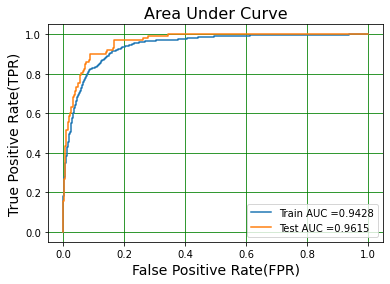

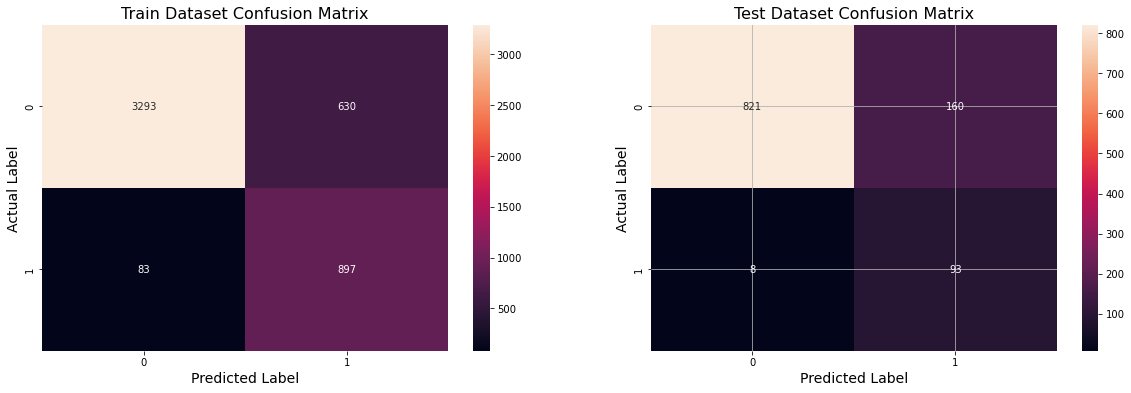

Best Threshold = 0.1114
Model AUC is : 0.9615
Model F1 Score is : 0.5254


In [18]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

####  GridSearchCV for DecisionTreeClassifier

In [19]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [20]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 150, 'min_samples_split': 500}
roc_auc_score : 0.9313700402167887


#### Train DecisionTreeClassifier with best hyperparameters

In [21]:
decision_tree = DecisionTreeClassifier(max_depth = 150, min_samples_split = 500)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=150, min_samples_split=500)

Train AUC =  0.9444546031514824
Test AUC =  0.9486177975595724


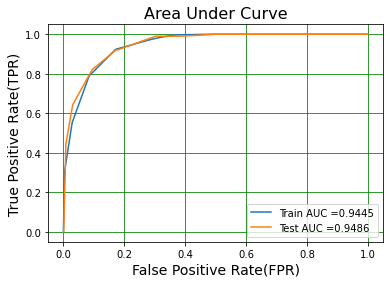

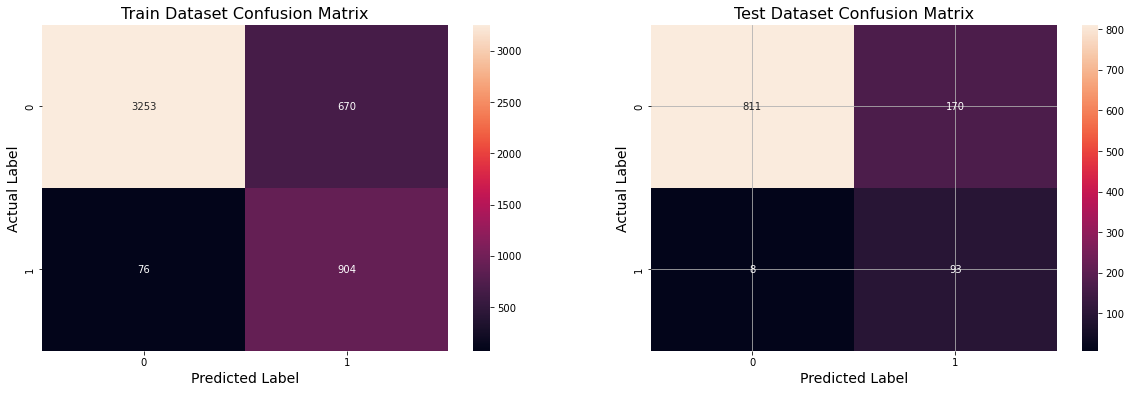

Best Threshold = 0.2787
Model AUC is : 0.9486
Model F1 Score is : 0.5110


In [22]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Prediction On Test Data

In [23]:
def pred_prob1(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred
def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [24]:
# Extract column names from X_train
column_names = x_test.columns
# Convert NumPy arrays to pandas DataFrames with the same column names as X_train
X_test_df = pd.DataFrame(x_test_std, columns=column_names)

In [25]:
pred = pred_prob1(decision_tree, x_test_std)
y_test_pred = pred_prob(decision_tree, x_test_std)
y_test_prediction = predict_with_best_t(y_test_pred, 0.2787)

In [26]:
X_test_df['Provider']=Final_Dataset_Provider_Test['Provider']

In [27]:
X_test_df['Prediction']=y_test_prediction
res=X_test_df[["Provider","Prediction"]]

In [28]:
display(res.head(10))
res['Prediction'].value_counts()

,Provider,Prediction
0,PRV51002,0
1,PRV51006,0
2,PRV51009,0
3,PRV51010,0
4,PRV51018,0
5,PRV51019,0
6,PRV51020,0
7,PRV51022,0
8,PRV51028,0
9,PRV51033,0


0    1021
1     332
Name: Prediction, dtype: int64

#### RandomSearchCV for SupportVectorClassifier

In [29]:
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [30]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.9395504062797613


In [31]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

CalibratedClassifierCV(estimator=LinearSVC(C=0.5))

Train AUC =  0.9484468883143369
Test AUC =  0.9590335180307022


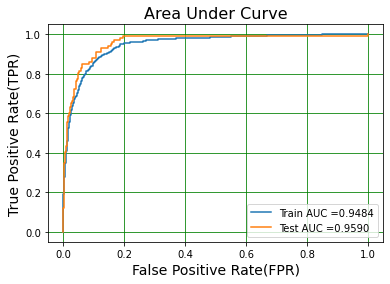

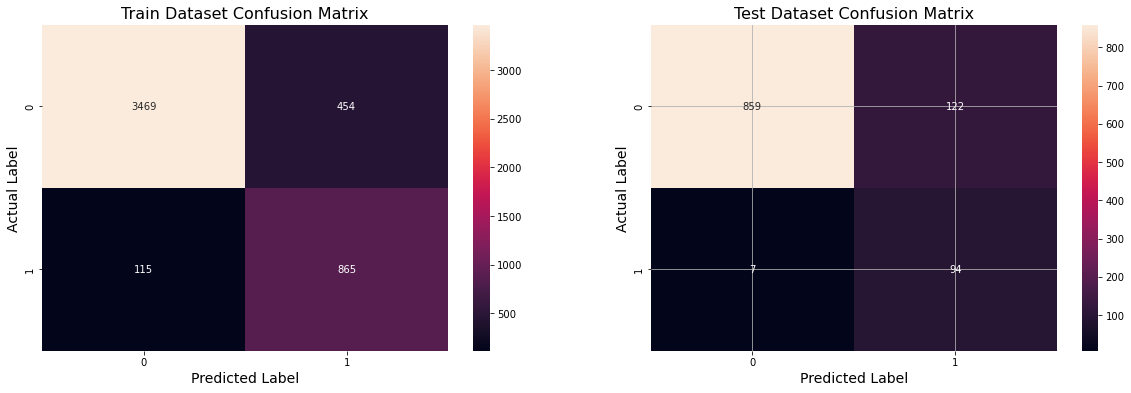

Best Threshold = 0.1518
Model AUC is : 0.9590
Model F1 Score is : 0.5931


In [32]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### On Test Set

In [33]:
# Extract column names from X_train
column_names = x_test.columns
# Convert NumPy arrays to pandas DataFrames with the same column names as X_train
X_test_df_sv = pd.DataFrame(x_test_std, columns=column_names)  ###
pred = pred_prob1(clb_clf_svc, x_test_std)
y_test_pred = pred_prob(clb_clf_svc, x_test_std)
y_test_prediction = predict_with_best_t(y_test_pred,0.1518)
X_test_df_sv['Provider']=Final_Dataset_Provider_Test['Provider'] ###
X_test_df_sv['Prediction']=y_test_prediction
res2=X_test_df_sv[["Provider","Prediction"]]
display(res2.head(10))
res2['Prediction'].value_counts()

,Provider,Prediction
0,PRV51002,0
1,PRV51006,0
2,PRV51009,0
3,PRV51010,0
4,PRV51018,1
5,PRV51019,0
6,PRV51020,0
7,PRV51022,0
8,PRV51028,0
9,PRV51033,0


0    1105
1     248
Name: Prediction, dtype: int64

<h2> Feature Selection Using Random Forest </h2>

In [34]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 19.99% and Non-Fraud Percentage = 80.01%


In [35]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os, y_tr_os)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [36]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9723982766933629


In [37]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=2, max_features='sqrt', max_depth=20, random_state=42)
random_forest.fit(x_tr_os, y_tr_os)

RandomForestClassifier(max_depth=20, n_estimators=400, random_state=42)

Train AUC =  1.0
Test AUC =  0.9542697389004956


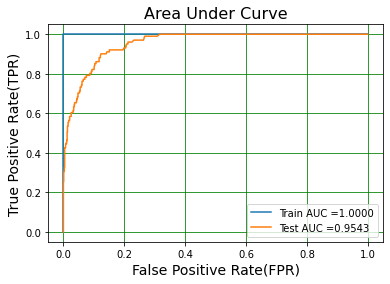

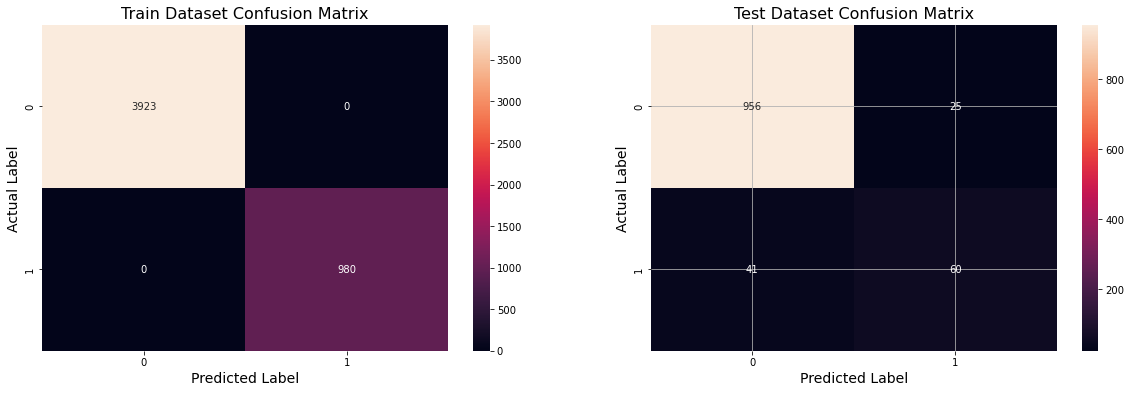

Best Threshold = 0.6000
Model AUC is : 0.9543
Model F1 Score is : 0.6452


In [38]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

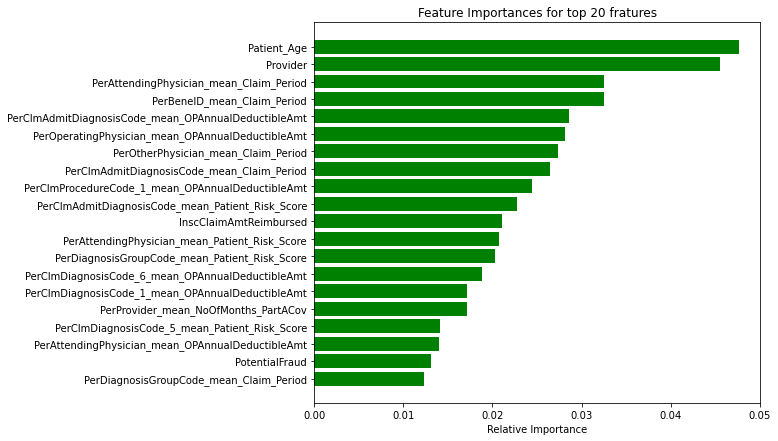

In [39]:
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

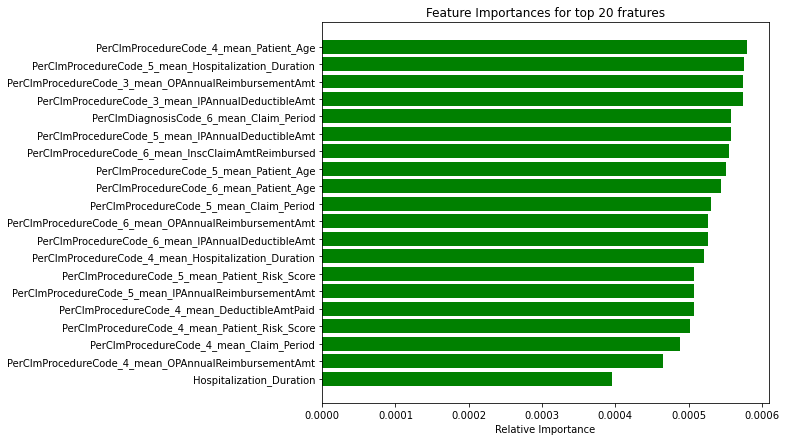

In [40]:
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
least_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(least_20_indices)), importance_of_feature[least_20_indices], color='g', align='center')
plt.yticks(range(len(least_20_indices)), [features[i] for i in least_20_indices])
plt.xlabel('Relative Importance')
plt.show()

In [42]:
len(importance_of_feature[importance_of_feature>0.001])

154

### Take top 154 features based on feature importance

In [43]:
# take all the feature columns in a list
features = list(x_train.columns)
imp_feature_indx = np.argsort(random_forest.feature_importances_)[::-1]
imp_value = np.take(random_forest.feature_importances_, imp_feature_indx[:154])
imp_feature_name = list(np.take(features, imp_feature_indx[:154]))

In [44]:
x_train_imp_features = x_train[imp_feature_name]
x_train_imp_features.shape

(5410, 154)

In [45]:
x_test_imp_features = x_test[imp_feature_name]
x_test_imp_features.shape

(1353, 154)

In [46]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train_imp_features)
x_train_if_std = standard_scaler.transform(x_train_imp_features)
x_test_if_std = standard_scaler.transform(x_test_imp_features)

In [47]:
# split the data into train and test
x_tr_if, x_val_if, y_tr_if, y_val_if = train_test_split(x_train_if_std, y_train, test_size=0.2,random_state=42,stratify=y_train)
x_tr_if.shape, x_val_if.shape, y_tr_if.shape, y_val_if.shape

((4328, 154), (1082, 154), (4328,), (1082,))

In [48]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os_if, y_tr_os_if = oversample.fit_resample(x_tr_if, y_tr_if)
counter = Counter(y_tr_os_if)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 19.99% and Non-Fraud Percentage = 80.01%


In [49]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os_if, y_tr_os_if)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [50]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9385447345453196


In [51]:
log_reg = LogisticRegression(C=1.0, penalty='l2')
log_reg.fit(x_tr_os_if, y_tr_os_if)

LogisticRegression()

Train AUC =  0.944276818553065
Test AUC =  0.9554404981782582


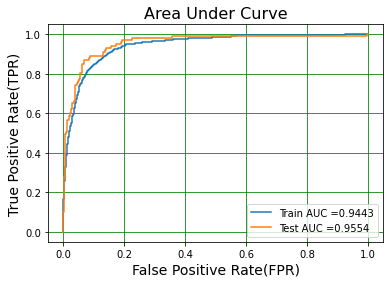

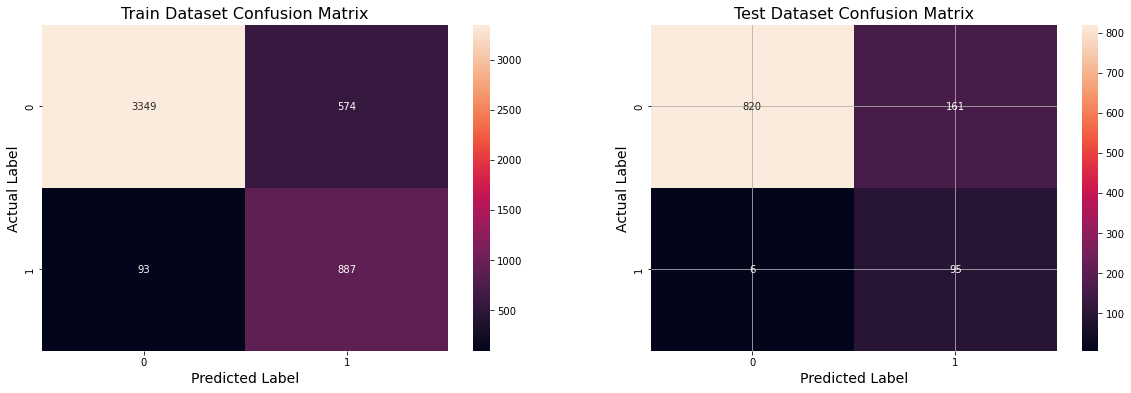

Best Threshold = 0.1157
Model AUC is : 0.9554
Model F1 Score is : 0.5322


In [52]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Random Forest with important features

In [53]:
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os_if, y_tr_os_if)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [54]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 20}
roc_auc_score : 0.9696289049546765


In [55]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os_if, y_tr_os_if)

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=5,
                       n_estimators=400, random_state=42)

Train AUC =  0.9999986994542911
Test AUC =  0.9565910719512318


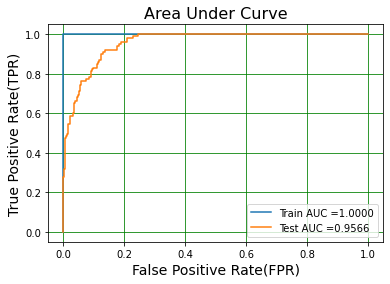

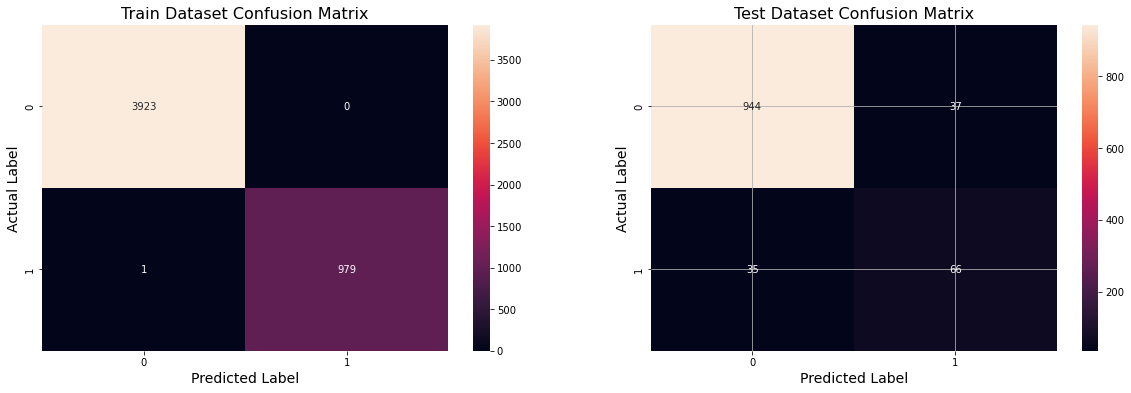

Best Threshold = 0.5091
Model AUC is : 0.9566
Model F1 Score is : 0.6471


In [56]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [57]:
# Extract column names from X_train
column_names = x_test.columns
# Convert NumPy arrays to pandas DataFrames with the same column names as X_train
X_test_df_rf = pd.DataFrame(x_test_std, columns=column_names)  ###
pred = pred_prob1(random_forest, x_test_if_std)
y_test_pred = pred_prob(random_forest, x_test_if_std)
y_test_prediction = predict_with_best_t(y_test_pred, 0.5091)
X_test_df_rf['Provider']=Final_Dataset_Provider_Test['Provider'] ###
X_test_df_rf['Prediction']=y_test_prediction
res3=X_test_df_rf[["Provider","Prediction"]]
display(res3.head(10))
res3['Prediction'].value_counts()

,Provider,Prediction
0,PRV51002,0
1,PRV51006,0
2,PRV51009,0
3,PRV51010,0
4,PRV51018,0
5,PRV51019,0
6,PRV51020,0
7,PRV51022,0
8,PRV51028,0
9,PRV51033,0


0    1255
1      98
Name: Prediction, dtype: int64

### 